In [ ]:
%%capture
%pip install gurobipy
import warnings
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import Model
from gurobipy import GRB
warnings.filterwarnings('ignore')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# multiple attention block attention NN model
# Define a reusable attention block
class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout=0.1):
        super().__init__()
        # Multi-head attention layer
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)

        # Feedforward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feedforward with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))

        return x


# Full attention-based model with multiple stacked attention blocks
class AttentionModel(nn.Module):
    def __init__(self, hidden_dim=128, input_dim=4, num_heads=4, num_layers=3):
        super(AttentionModel, self).__init__()

        # Feature embedding layer (shared across options)
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # Stack of multiple attention blocks
        self.attn_blocks = nn.Sequential(*[
            AttentionBlock(hidden_dim, num_heads) for _ in range(num_layers)
        ])

        # Output layer to score each option
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch_size, 3, 4]
        embedded = self.embedding(x)  # → [batch_size, 3, hidden_dim]
        attn_output = self.attn_blocks(embedded)  # pass through attention layers

        # Project to scalar scores for each alternative
        scores = self.output_layer(attn_output).squeeze(-1)  # → [batch_size, 3]

        # Convert to log-probabilities across options
        return F.log_softmax(scores, dim=1)


In [ ]:
class ResidualInvariantModel(nn.Module):
    def __init__(self, hidden_dim=64):
        super(ResidualInvariantModel, self).__init__()
        self.shared_mlp = nn.Sequential(
            nn.Linear(4, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size = x.size(0)
        x_reshaped = x.view(-1, 4)  # [batch_size * 3, 4]
        out = self.shared_mlp(x_reshaped)
        scores = self.output_layer(out).view(batch_size, 3)  # [batch_size, 3]
        return F.log_softmax(scores, dim=1)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset

df = pd.read_csv('/content/training_data.csv')


# Function to reshape each row into [3, 4]
def reshape_row(row):
    group = row["GROUP"]
    member = row["MEMBER"]
    alt_a = [group, member, row["DT_A"], row["COST_A"]]
    alt_b = [group, member, row["DT_B"], row["COST_B"]]
    alt_c = [group, member, row["DT_C"], row["COST_C"]]
    return np.array([alt_a, alt_b, alt_c])

# Apply reshape to entire DataFrame
X = np.stack(df.apply(reshape_row, axis=1))
y = df["CHOICE"].values

# Normalize platform specific feats (DT + Cost)
for i in range(X.shape[0]):
  dt_mean = X[i,:,2].mean() # delivery time mean
  dt_std = X[i,:,2].std() # delivery time standard dev
  X[i,:,2] = (X[i,:,2] - dt_mean) / (dt_std + 1e-8) # Normalize times
  cost_mean = X[i,:,3].mean() # cost mean
  cost_std = X[i,:,3].std() # cost std
  X[i,:,3] = (X[i,:,3] - cost_mean) / (cost_std + 1e-8) # Normalize costs

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ChoiceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ChoiceDataset(X_train, y_train)
val_dataset = ChoiceDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, epochs=15, lr=1e-3, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Use validation accuracy to guide learning rate reduction
    LR_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold=0.005, verbose=True)

    criterion = nn.NLLLoss()

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []
    learning_rate_history = []

    best_validation_acc = 0
    epochs_no_improvement = 0

    for epoch in range(epochs):
        model.train()
        correct = 0
        running_loss = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(output.data, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        running_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                running_loss += loss.item()
                _, preds = torch.max(output.data, 1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss = running_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Step the scheduler based on validation accuracy
        LR_scheduler.step(val_acc)

        # Track learning rate for plotting and to visualize dynamic chnages through schedluer
        current_lr = optimizer.param_groups[0]['lr']
        learning_rate_history.append(current_lr)
        print(f"Current Learning Rate: {current_lr:.2e}")

        # Save best model if validation improves
        if val_acc > best_validation_acc:
            best_validation_acc = val_acc
            epochs_no_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improvement += 1
            if epochs_no_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        print(f"Epoch {epoch + 1} / {epochs} — Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} |  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Plot training and validation loss
    plt.figure(figsize = (7, 5))
    plt.plot(train_losses, label = 'Train Loss')
    plt.plot(val_losses, label = 'Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize = (7, 5))
    plt.plot(train_accs, label = 'Train Accuracy')
    plt.plot(val_accs, label = 'Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Load and return best model based on validation accuracy
    model.load_state_dict(torch.load('best_model.pth'))
    return model


Current Learning Rate: 1.00e-04
Epoch 1 / 30 — Train Loss: 0.8508, Train Acc: 0.5771 |  Val Loss: 0.7689, Val Acc: 0.6557
Current Learning Rate: 1.00e-04
Epoch 2 / 30 — Train Loss: 0.7630, Train Acc: 0.6559 |  Val Loss: 0.7544, Val Acc: 0.6629
Current Learning Rate: 1.00e-04
Epoch 3 / 30 — Train Loss: 0.7509, Train Acc: 0.6718 |  Val Loss: 0.7440, Val Acc: 0.6657
Current Learning Rate: 1.00e-04
Epoch 4 / 30 — Train Loss: 0.7422, Train Acc: 0.6809 |  Val Loss: 0.7457, Val Acc: 0.6643
Current Learning Rate: 1.00e-04
Epoch 5 / 30 — Train Loss: 0.7364, Train Acc: 0.6773 |  Val Loss: 0.7470, Val Acc: 0.6693
Current Learning Rate: 1.00e-04
Epoch 6 / 30 — Train Loss: 0.7366, Train Acc: 0.6839 |  Val Loss: 0.7362, Val Acc: 0.6729
Current Learning Rate: 1.00e-04
Epoch 7 / 30 — Train Loss: 0.7260, Train Acc: 0.6837 |  Val Loss: 0.7440, Val Acc: 0.6707
Current Learning Rate: 1.00e-04
Epoch 8 / 30 — Train Loss: 0.7264, Train Acc: 0.6845 |  Val Loss: 0.7278, Val Acc: 0.6750
Current Learning Rate: 5

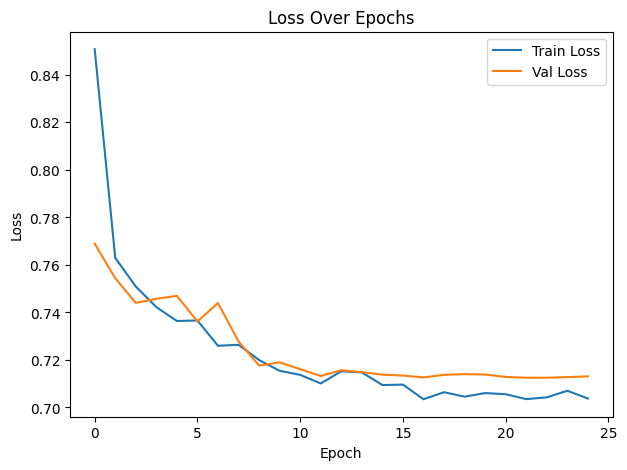

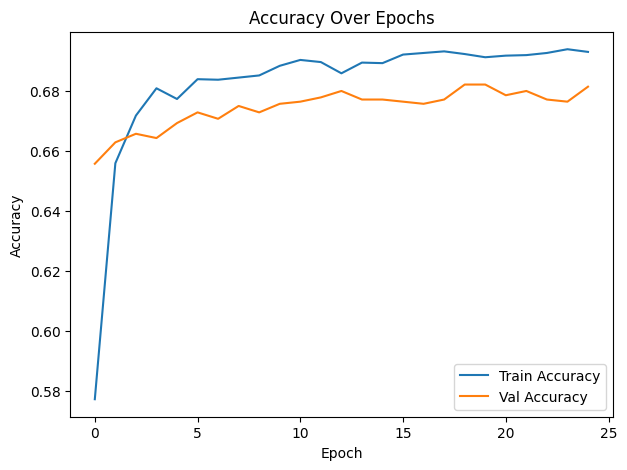

In [ ]:
model = AttentionModel(hidden_dim = 128, num_heads = 8)
trained_model = train_model(model, train_loader, val_loader, epochs= 30 , lr = .0001, patience = 6 )

In [ ]:
# Save the trained model to a file (replace filename if needed)
import torch
PATH = "attention_model.pt"  # or "residual_model.pt"
torch.save(trained_model, PATH)

In [ ]:
def test(input_features, model_PATH= PATH):
    """
    input_features: numpy array of shape [batch_size, 3, 4]
    returns: predicted class probabilities of shape [batch_size, 3]
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AttentionModel(hidden_dim = 128, num_heads = 4)

    model.load_state_dict(torch.load(model_PATH, map_location= device))
    model.to(device)
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(input_features, dtype=torch.float32).to(device)
        logits = model(x_tensor)
        return torch.exp(logits).cpu().numpy()  # returns probabilities

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confusion_matrix(model_PATH, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AttentionModel(hidden_dim = 128, num_heads = 4)
    model.load_state_dict(torch.load('best_model.pth'))  # load weights
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(X_batch).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C'])
    disp.plot()

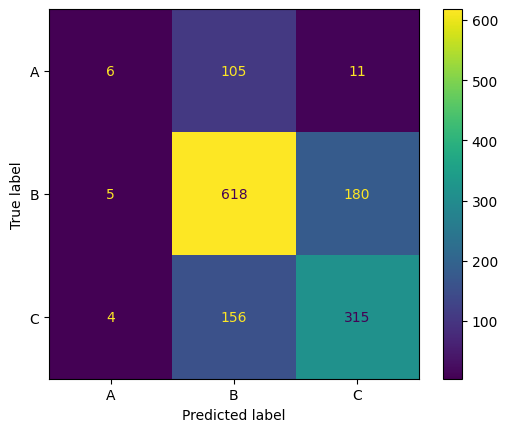

In [ ]:
show_confusion_matrix(trained_model, val_loader)